# Train a model using fast.ai

Now it is your turn to train a model on this same dataset using fast.ai!

## Setup

### Import necessary libraries

In [54]:
# This file contains all the main external libs we'll use
from fastai.imports import * #used for fastai
from IPython import display #used to display media in notebook
import soundfile as sf #used to load sound files
import matplotlib.pyplot as plt #used to plot in notebook
import scipy
from scipy.signal import hann
from scipy.fftpack import rfft

import pandas as pd
from fastai.data.all import *
from fastai.data.external import *
from fastai.vision.all import *
import librosa;
import os;
import torch;
import torchaudio;
import io;
import librosa.display;

### Check if CUDA is available - This will be a problem later if this doesn't work

In [29]:
print(torch.cuda.is_available())

True


### Setup dataset paths

In [30]:
DATA_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'full_data'))
SAMPLE_DATA_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'sample_data'))

DATA_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'whale')
DATA_NOT_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'not_whale')
path = Path(DATA_ROOT_DIR)

### Create Fast.AI Transformer to Load Audio to Spectrogram

In [114]:
# Convert a Matplotlib figure to a PIL Image and return it
# This is used to avoid writing to disk, which is an expensive operation and would slow down training
# Alternatively, we could precompute the images but that wouldn't let us experiment as easily
def figure_to_image(fig):
    
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PILImage.create(buf)
    return img

# Lots of libraries and methods for generating a spectrogram
# Under the hood all these algorithms rely on a Fast Fourier Transform
# Originally, I wanted to use torchaudio because that is CUDA enabled and can be accelerated on GPU
# Unfortunately, the shape of the data returned simply did not make any sense and working with tensors
# as opposed to numpy arrays was incredibly annoying. It just didn't work.
# I tried other libraries as well but ultimately settled on librosa since it seems the most widely used
# There exist fast.ai packages like fastaudio and other forks but like many open-source things they are unmaintained
# Using those type of packages breaks the dependencies and on my environment forced a non-CUDA
# accelerated version of pytorch which is useless
def create_spectrogram(file_path):
    samples, sample_rate = librosa.core.load(file_path)
    
    # Compute spectrogram, using some sensible defaults
    # Opportunities here to tweak possibly, just not sure how much it would help
    # We don't use Nicholas' settings as for some reason they get bad results with this library
    D = librosa.stft(samples, n_fft=1024, hop_length=64, window="han", center=False)  # STFT of y
    
    # Normalize to decibals
    S_dB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_dB, sample_rate

def spectrogram_to_image(spec, sr, hop_length, y_axis='hz', x_axis='time'):
    # this uses matplot lib to plot the spectrogram but we don't show it in the notebook
    # instead we use figure_to_image to save it to memory as a fast.ai Image (PILImage)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    ax.set_ylim((0, 1000)) #this line cuts off the frequencies at 1000Hz, none of the files have frequencies above this
    ax.axis('off')
    plt.tight_layout(pad=0)
    
    # use the same spectrogram coloring as used in Nicholas Kridler's winning solution
    librosa.display.specshow(spec, sr=sr, y_axis=y_axis, x_axis=x_axis, hop_length=hop_length, cmap="hsv_r")
    
    # write to in-memory file, the whole matplotlib plotting and saving to memory is a hack to avoid
    # saving a file to the disk which would be extremely slow
    # it is also a hack because using the output from create_spectrogram is incredibly difficult
    # the result would be in the same shape as an image and you can plot it as if it were
    # but some values are floats and have negatives, you'd have to normalize to 0-255, as well as cast the type
    # then the result is a single channel image, the pre-trained nets expect a 3-channel image so while
    # you can view the image successfully, you can't used pre-trained models
    # as I write this, probably my concern is that I don't know how many of these matplotlib operations are
    # CPU-bound so while this is faster than being blocked by disk-io, its slower than doing everything with tensors
    # that said, librosa which is what we use for computing the spectrogram, runs on the CPU
    # performance wise, switching to a library that is CUDA enabled could speed up the underlying fast fourier transform
    # but another performance optimization is removing the dependency on matplotlib but good luck with that
    fig = plt.gcf()
    img = figure_to_image(fig)
    plt.close('all')
    return img

# this is an alternative type of spectrogram, its here in case you want to try to use it
# my understanding is that it normalizes the spectrogram based on what humans can perceive which is
# good for some types of problems, but this problem I think isn't really about how humans hear whales
# theres more tweakable settings and people really seem to like mel spectrograms so there might be something here
def create_mel_spectrogram(audio):
    audio, sample_rate = librosa.core.load(audio)
    # Compute mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, fmax=sample_rate/2, center=False)
    
    # Normalize to decibals
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB, sample_rate

# I chose to load the audio files directly into fast.ai using the DataBlock API.
# Alternatively, we could have pre-computed all the spectrograms in the 00_getting_started.ipynb but
# I decided against it because then it would be unlikely for anyone to actually make modifications to the images
# Writing 40,000 files to disk is painfully slow so you wouldn't even be able to get started quickly
# This method creates a transformer which can take paths to audio files and transform them into spectrograms
# The API could be improved a bit to remove the hard-coding of hop_length but overall pretty happy with the result
# aside from the hackiness of spectrogram_to_image, but if you do some research you will see lots of people doing
# pretty terribly things as well. So this one I think is pretty clever
class SpecgramTransform(Transform):
    def __init__(self): self.aug = create_spectrogram
    def encodes(self, audio_file: Path):
        aug_img, sample_rate = self.aug(audio_file)
        image = spectrogram_to_image(aug_img, sr=sample_rate, hop_length=192)
        return image

# Alternative transformer for generating images of Mel Spectrograms
# Beware: Mel Spectrograms have different sizes then regular ones.
# Although I'm pretty sure the resizing method in the transformation pipeline probably handles it, untested
class MelSpecgramTransform(Transform):
    def __init__(self): self.aug = create_mel_spectrogram
    def encodes(self, audio_file: Path):
        aug_img, sample_rate = self.aug(audio_file)
        image = spectrogram_to_image(aug_img, sr=sample_rate, hop_length=192)
        return image
    
# We may need to crop images. For example, whats the highest frequency sound a whale can even make?
# Whatever it is, it could be reasonable to cut-off the image at frequencies we know a whale call couldn't exist
# Ultimately, images will need to be square I believe so they would need to get filled with something
# The reason I created this transform is because fast.ai doesn't give you a transformer for precision cropping
# You either crop and cut out the center or you don't crop at all
# This transformer lets you optionally crop from any direction and leaves sides alone that you don't specify crops for
class CropImageTransform(Transform):
    def __init__(self, left=None, upper=None, right=None, lower=None):
        self.aug = self.__crop_image
        self.box = (left, upper, right, lower)
    
    def __compute_box(self, image):
        # get current dimensions of image
        # *other is because we don't know if we will receive two elements or more
        # we get two for a greyscale image, we get three for a RGB
        h, w, *other = image.shape
        
        #get desired crop entered by user
        left, upper, right, lower = self.box
        
        #don't crop sides that user didn't want cropped
        left = 0 if left is None else left
        upper = 0 if upper is None else upper
        right = w if right is None else right
        lower = h if lower is None else lower
        
        #save computed box
        self.box = (left, upper, right, lower)
        
    def __crop_image(self, image):
        self.__compute_box(image)
        print(self.box)
        image_cropped = image.crop(self.box)
        return image_cropped
        
    # this transformer works on PILImages (fast.ai)
    # this transfomer does not work on PIL.Image (Pillow/PIL)
    def encodes(self, image: PILImage):
        cropped_image = self.aug(image)
        return cropped_image

Check one file to see if data loaded correctly

Specgram Size: (288, 432)


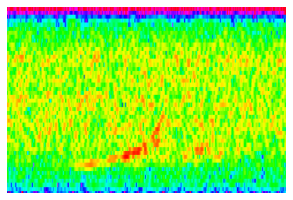

In [115]:
files = get_files(path)
audio_file = files[0]

spec, sample_rate = create_spectrogram(audio_file)

spec_image = spectrogram_to_image(spec, sr=sample_rate, hop_length=192)
show_image(spec_image)

print(f"Specgram Size: {spec_image.shape}")

Preview results of CropImageTransform for reference in case you need to crop

(0, 128, 432, 288)
Specgram Size: (160, 432)


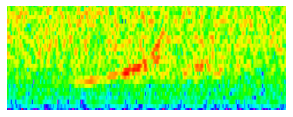

In [116]:
tfm = CropImageTransform(upper=128)
cropped_spec = tfm((spec_image))
show_image(cropped_spec);
print(f"Specgram Size: {cropped_spec.shape}")

## Model Training

### Load dataset

This part maybe looks a little tricky but this uses Fast.AI's DataBlock API for generic loading. `get_files` is a generic loader that takes in everything in the `path` when you call `dblock.dataloaders(path)`. `get_files` is just a function provided by fast.ai and we are passing the function by name, but it doesn't get called yet until you use the dataloader. Since the audio files are organized in folders in the path, DataBlock/DataLoader is smart enough to know that each folder represents a category of data. 

Our data set is comprised of two types of data, audio files which we use a `TransformBlock` for and the labels which are represented by `CategoryBlock`. Based on what you pick here lets fast.ai be able to support additional features. So for example an `ImageBlock` responds to more things than a `TransformBlock`. We don't have a choice here because while we will _eventually_ load data in the form of a spectrogram image, at this moment our dataset is just a collection of file paths and labels. If we tried to use an `ImageBlock` it would throw an error saying `Path` is not of type `Image` or something like that.

Additionally, DataBlocks can have one or more item transformers and one or more batch transformers. Item transformers are executed on each item. Batch transfomers are executed on the whole batch. The default transformer pipeline I laid out here does the following:

* Transform each file path into a fast.ai friendly image of its corresponding spectrogram
* Resize the each image such that the largest dimension of that image is 224 pixels, while the other is possibly smaller
* Turn the image into a square by making all sides 224 while centering the image and padding the empty space with zeroes. Annoyingly, padding is applied randomly on the borders of the  smaller dimensions. If we hate this, we can write our own ExtendTransform. I didn't because there are arguments that this type of augmentation helps the model generalize.

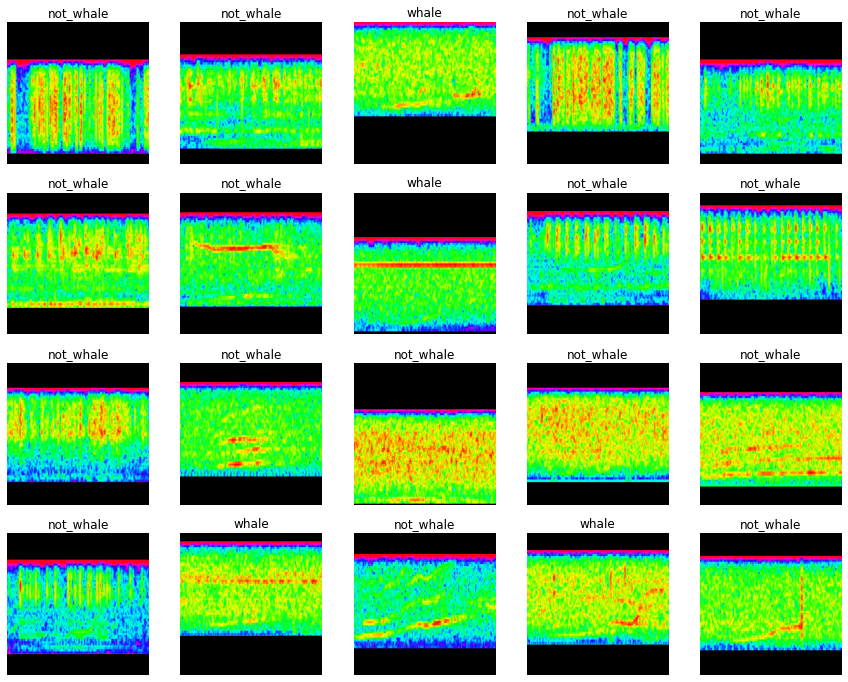

In [119]:
dblock = DataBlock(
    blocks = [TransformBlock, CategoryBlock],
    get_items = get_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms = [ SpecgramTransform(), RatioResize(224), Resize(224, method="pad", pad_mode="zeros") ]
)
dls = dblock.dataloaders(path)
dls.show_batch(max_n=20)

### Train

In [120]:
learn = vision_learner(dls, resnet18, metrics=error_rate, pretrained=False)
learn.fit(10)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

### Export

In [ ]:
TODO: by you

## Brainstorm ideas for improvement

Don't improve things in this notebook. Save it for the later one. But just jot down some ideas you can think of to improve the results.

* todo by you